In [1]:
#@title Imports & Utils
# !pip install -q git+https://github.com/abhijeetgangan/jax-md.git

import jax.numpy as jnp
import numpy as onp
from jax import debug
from jax import jit
from jax import grad
from jax import random
from jax import lax
from jax.config import config

config.update('jax_enable_x64', True)
from jax_md import simulate
from jax_md import space
from jax_md import energy
from jax_md import elasticity
from jax_md import quantity
from jax_md import dataclasses
from jax_md.util import f64

# Other libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 

# LAMMPS data
# !wget https://raw.githubusercontent.com/abhijeetgangan/Silicon-data/main/Si-SW-MD/NVT-300K/lammps_nvt.dat
# !wget https://raw.githubusercontent.com/abhijeetgangan/Silicon-data/main/Si-SW-MD/NVE-300K/step_1.traj
data_lammps = pd.read_csv("lammps_nvt.dat", delim_whitespace="  ", header=None)
data_lammps = data_lammps.dropna(axis=1)
data_lammps.columns = ['Time','T','P','V','E','H']
t_l, T, P, V, E, H = data_lammps['Time'], data_lammps['T'], data_lammps['P'], data_lammps['V'], data_lammps['E'], data_lammps['H']

# Using units in JAX-MD (NVT simulation)

This notebook demonstrates the use of a unit system (metal units) for the simulation of the Silicon crystal containing 512 atoms in the NVT ensemble with the Stillinger-Weber potential. This notebook use lammps velocities and positions as a starting point for the simulation and for comparison.

More about the unit system https://docs.lammps.org/units.html

## Load LAMMPS positions and velocities.

In [2]:
lammps_step_0 = onp.loadtxt('step_1.traj', dtype=f64)

In [3]:
# Load positions from lammps
positions = jnp.array(lammps_step_0[:,2:5], dtype=f64)
# Load velocities from lammps
velocity = jnp.array(lammps_step_0[:,5:8], dtype=f64)
latvec = jnp.array([[21.724, 0.000000, 0.000000], [0.00000, 21.724, 0.00000],[0.00000, 0.0000, 21.724]])

## Units and simulation parameters


In [4]:
# Import unit system
from jax_md import units

# Metal units
unit = units.metal_unit_system()

In [5]:
# Simulation parameters
timestep = 1e-3
fs = timestep * unit['time']
ps = unit['time']
dt = fs
write_every = 100
box = latvec
T_init = 300 * unit['temperature']
Mass = 28.0855 * unit['mass']
key = random.PRNGKey(121)
steps = 5000

Array(1., dtype=float64)

In [6]:
# Logger to save data
log = {
'E': jnp.zeros((steps // write_every,)),
'P': jnp.zeros((steps // write_every,)),
'T': jnp.zeros((steps // write_every,)),
'kT': jnp.zeros((steps // write_every,)),
'state' : jnp.zeros((steps // write_every, 512, 3)),
}

## Simulation setup

In [7]:
# Setup the periodic boundary conditions. 
displacement, shift = space.periodic_general(latvec) 
dist_fun = space.metric(displacement) 
neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec, disable_cell_list=True)
energy_fn = jit(energy_fn)

# Extra capacity to prevent overflow
nbrs = neighbor_fn.allocate(positions, box=box, extra_capacity=2)


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [8]:

# NVT simulation
init_fn, apply_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt=dt, kT=T_init, tau=100 * dt, chain_length=3, chain_steps=1, sy_steps=1)
apply_fn = jit(apply_fn)
state = init_fn(key, positions, box=box, neighbor=nbrs, kT=T_init, mass=Mass)

# Restart from LAMMPS velocities
state = dataclasses.replace(state, momentum = Mass * velocity * unit['velocity'])

FOO


In [9]:
# import jax
# state = init_fn(key, positions, box=box, neighbor=nbrs, kT=T_init, mass=Mass)


## NVT simulation

In [10]:
@jit
def step_fn(i, state_nbrs):  
  state, nbrs = state_nbrs
  # Take a simulation step.
  t = i * dt
  state = apply_fn(state, neighbor=nbrs, kT=T_init)
  nbrs = nbrs.update(state.position, neighbor=nbrs)
  return state, nbrs
    
@jit
def outer_sim_fn(j, state_nbrs_log):
  state, nbrs, log = state_nbrs_log

  # Quantities to calculate
  K  = quantity.kinetic_energy(momentum = state.momentum, mass=Mass)
  E  = energy_fn(state.position, box=box, neighbor=nbrs)
  kT = quantity.temperature(momentum = state.momentum, mass=Mass)
  P  = quantity.pressure(energy_fn, state.position, box, K, neighbor=nbrs)

  # Save the quantities
  log['T'] = log['T'].at[j].set(simulate.nvt_nose_hoover_invariant(energy_fn, state, T_init, neighbor=nbrs))
  log['E'] = log['E'].at[j].set(E)
  log['kT'] = log['kT'].at[j].set(kT)
  log['P'] = log['P'].at[j].set(P)
  log['state'] = log['state'].at[j].set(state.position)
  # gr = jax.grad(energy_fn)(state.position, box=box, neighbor=nbrs)
  # debug.print('Step = {j} | Total Energy = {T}', j=j*write_every, T=gr)
  # log['grad'] = log['grad'].at[j].set(gr)

  # Print the quantities
  debug.print('Step = {j} | Total Energy = {T}', j=j*write_every, T=K+E)

  @jit
  def inner_sim_fn(i, state_nbrs):
    return step_fn(i, state_nbrs)
      
  state, nbrs = lax.fori_loop(0, write_every, inner_sim_fn, (state, nbrs))

  return state, nbrs, log

In [11]:
# displacement, shift = space.periodic_general(latvec) 
# # displacement, shift = space.periodic(latvec[0][0]) 
# shift(nnp.ones((3,))*21, nnp.zeros((3,))/100)

# nnp.ones((3,))/100 + nnp.ones((3,))/100

In [12]:
latvec

Array([[21.724,  0.   ,  0.   ],
       [ 0.   , 21.724,  0.   ],
       [ 0.   ,  0.   , 21.724]], dtype=float64)

In [13]:
state_r, nbrs_r, log_r = lax.fori_loop(0, int(steps/write_every), outer_sim_fn, (state, nbrs, log))

/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Step = 0 | Total Energy = -2200.4826561382047
Step = 100 | Total Energy = -2198.4044315213873
Step = 200 | Total Energy = -2194.896508716625
Step = 300 | Total Energy = -2190.66092395083
Step = 400 | Total Energy = -2186.159406237695
Step = 500 | Total Energy = -2182.0269534285762
Step = 600 | Total Energy = -2178.6853137851726
Step = 700 | Total Energy = -2177.767341757199
Step = 800 | Total Energy = -2179.2815316785486
Step = 900 | Total Energy = -2181.39743508516
Step = 1000 | Total Energy = -2182.529022621795
Step = 1100 | Total Energy = -2181.6170750503566
Step = 1200 | Total Energy = -2179.909138630441
Step = 1300 | Total Energy = -2178.8112153965326
Step = 1400 | Total Energy = -2179.084949417538
Step = 1500 | Total Energy = -2180.635759524732
Step = 1600 | Total Energy = -2181.7062586083334
Step = 1700 | Total Energy = -2181.7229006615466
Step = 1800 | Total Energy = -2180.491816534786
Step = 1900 | Total Energy = -2179.396425467039
Step = 2000 | Total Energy = -2179.0661387369

In [14]:
# Check if neighbors overflowed
# print(nbrs_r.did_buffer_overflow)

import mdtraj as md
import pandas as pd

# traj, _ = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb').topology.to_dataframe()

# print(samples.shape)
# raise Exception
def make_pdb(traj, name):
    n = 512

    new_t = pd.DataFrame({'name' : ['H']*n,
                        'element' : ['H']*n,
                        'serial' : range(n),
                        'resSeq' : [0]*n,
                        'resName' : ['0']*n,
                        'chainID' : [0]*n,

                        
                        })


    top = md.Topology.from_dataframe(new_t)
    # # states = np.where(np.isnan(states), 0, states)
    traj = md.Trajectory(xyz=traj, topology=top)

    traj.save_pdb('./data/' + name + '.pdb')

make_pdb(log_r['state'], 'silicon_langevin')

## Comparison plot

Note that you have to reconvert the units again.

In [17]:
Nsteps = int(steps/write_every)
t = jnp.arange(0, Nsteps,dtype=f64) * timestep * write_every

/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_4994/739867998.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


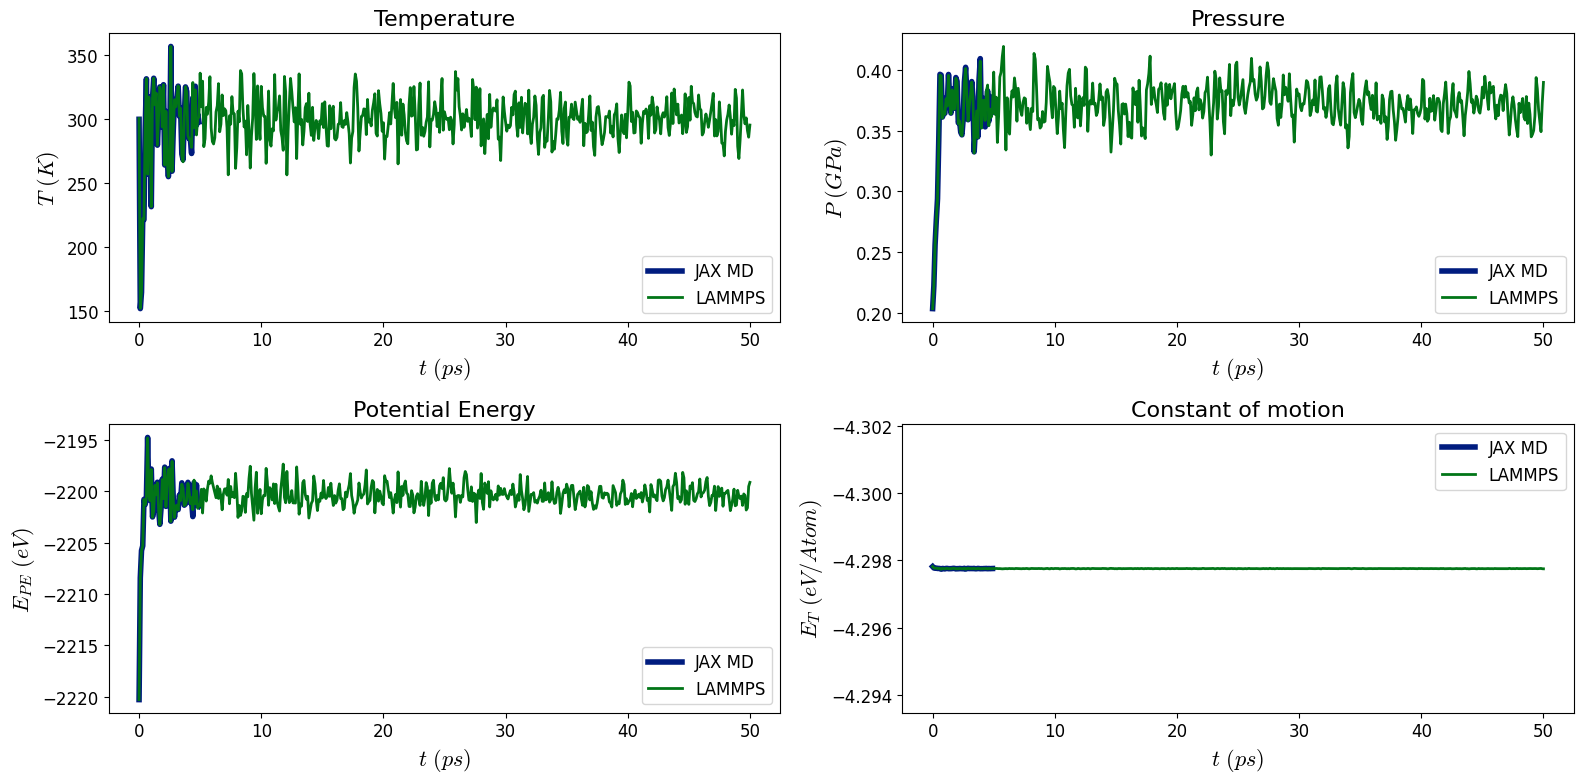

In [18]:
plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(16, 8))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(t, log_r['kT'] / unit['temperature'], lw=4, label='JAX MD')
ax1.plot(t_l, T, lw=2, label='LAMMPS')
ax1.set_title('Temperature', fontsize=16)
ax1.set_ylabel("$T\ (K)$", fontsize=16)
ax1.set_xlabel("$t\ (ps)$", fontsize=16)
ax1.legend()

ax2 = plt.subplot(2, 2, 2)
ax2.plot(t, (log_r['P'] / unit['pressure']) / 10000, lw=4, label='JAX MD')
ax2.plot(t_l, P/10000, lw=2, label='LAMMPS')
ax2.set_title('Pressure', fontsize=16)
ax2.set_ylabel("$P\ (GPa)$", fontsize=16)
ax2.set_xlabel("$t\ (ps)$", fontsize=16)
ax2.legend()

ax3 = plt.subplot(2, 2, 3)
ax3.plot(t, log_r['E'], lw=4, label='JAX MD')
ax3.plot(t_l, E, lw=2, label='LAMMPS')
ax3.set_title('Potential Energy', fontsize=16)
ax3.set_ylabel("$E_{PE}\ (eV)$", fontsize=16)
ax3.set_xlabel("$t\ (ps)$", fontsize=16)
ax3.legend()

ax4 = plt.subplot(2, 2, 4)
ax4.plot(t, log_r['T']/512, lw=4, label='JAX MD')
ax4.plot(t_l, H/512, lw=2, label='LAMMPS')
ax4.set_title('Constant of motion', fontsize=16)
ax4.set_ylabel("$E_{T}\ (eV/Atom)$", fontsize=16)
ax4.set_xlabel("$t\ (ps)$", fontsize=16)
ax4.set_ylim(jnp.mean(log_r['T']/512) - jnp.mean(log_r['T']/512)/1000 , jnp.mean(log_r['T']/512) + jnp.mean(log_r['T']/512)/1000)
ax4.legend()

fig.tight_layout()

In [73]:
import numpy.linalg as npl
# import seaborn as sns
import matplotlib.pyplot as plt 
from plotting import rama_plot
from jax_md.simulate import Sampler
from jax_md import space, quantity
from jax_md import simulate, energy
import math
import jax
import scipy
import jax.numpy as nnp

# displacement, shift = space.periodic(latvec[0][0]) 


BOLTZMAN = 0.001987191
T = 300
# nlogp = lambda x : (x**2).sum()/2

# neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec, disable_cell_list=True)
# # Extra capacity to prevent overflow
# nbrs = neighbor_fn.allocate(positions, box=box, extra_capacity=2)

# # NVT simulation
# init_fn, apply_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt=dt, kT=T_init, tau=100 * dt, chain_length=3, chain_steps=1, sy_steps=1)
# apply_fn = jit(apply_fn)
# state = init_fn(key, positions, box=box, neighbor=nbrs, kT=T_init, mass=Mass)

# Restart from LAMMPS velocities
# state = dataclasses.replace(state, momentum = Mass * velocity * unit['velocity'])


# nlogp = lambda nbrs: lambda x : ((x**2)/2.0).sum() # energy_fn(nnp.reshape(x, state.position.shape), neighbor=nbrs, box=box) / (BOLTZMAN * T)
nlogp = lambda nbrs: lambda x : energy_fn(nnp.reshape(x, state.position.shape), neighbor=nbrs, box=box) / (unit['temperature'] * T)
value_grad = lambda nbrs : jax.value_and_grad(nlogp(nbrs))


class MD():


  def __init__(self, d, nbrs):
    self.d = d
    self.nbrs = nbrs

  def grad_nlogp(self, x):
    return value_grad(self.nbrs)(x)

  def transform(self, x):
    # return x 
    out = nlogp(self.nbrs)(x) * (unit['temperature'] * T)
    # jax.debug.print(out.item())
    return out

  def prior_draw(self, key):

    # return nnp.reshape(state.position, math.prod(state.position.shape))
    return nnp.reshape(state_r.position, math.prod(state_r.position.shape))


In [74]:
# nbrs = neighbor_fn.allocate(positions, box=box, extra_capacity=2)

eps_in_si = 2*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * T)
si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
eps_val = eps_in_si * si_to_gmol

target = MD(d = math.prod(state.position.shape), nbrs=nbrs)
sampler = Sampler(target, shift_fn=shift, masses=nnp.zeros(512*3,)+Mass, eps=eps_val,  frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0)
# , masses = jax.numpy.tile(mol.masses,3), frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0, L = 30*eps_val,
                #   eps=eps_val)

In [75]:
eps_val

Array(1.43503523, dtype=float64, weak_type=True)

In [76]:

chain_length = 10000
num_chains = 1
samples, energies, L, eps = sampler.sample(chain_length, num_chains, output= 'detailed',
                                )

In [77]:
print(log_r['E'].var())
samples.var()

12.304136592143402


Array(0.17277165, dtype=float64)

In [57]:
samples.shape
make_pdb(nnp.reshape(samples[::10, :], (100, 512, 3)), 'silicon_mclmc')

In [21]:
x_initial = target.prior_draw(jax.random.PRNGKey(0))**2
x, u, l, g, key = sampler.get_initial_conditions(x_initial, jax.random.PRNGKey(0))
# out = sampler.sample_normal(10, x, u, l, g, key, 30.0, 1.0, nnp.ones_like(x), 1)

xx, uu, ll, gg, kinetic_change, key, time = sampler.dynamics(x, u, g, key, 0.0, 30.0, 1.0, nnp.ones_like(x))

In [24]:
# nnp.max(nnp.argwhere(samples[4] > 21))
# samples[0].mean()
nnp.min(samples)

Array(1.50447813e-09, dtype=float64)

In [49]:
# steps = 
Nsteps = chain_length
t = jnp.arange(0, Nsteps,dtype=f64) * timestep * write_every
# unit['temperature']

Text(0.5, 0, '$t\\ (ps)$')

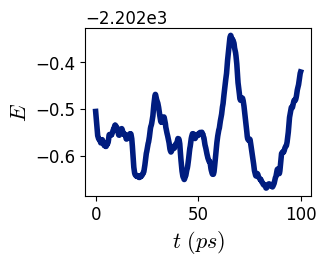

In [50]:
ax1 = plt.subplot(2, 2, 1)
ax1.plot(t[:], samples[::1], lw=4, label='JAX MD')
# ax1.plot(t_l, T, lw=2, label='LAMMPS')
# ax1.set_title('Temperature', fontsize=16)
ax1.set_ylabel("$E$", fontsize=16)
ax1.set_xlabel("$t\ (ps)$", fontsize=16)
# ax1.legend()

# samples


In [52]:
energy_fn(nnp.reshape(state.position, state.position.shape), nbrs)

Array(-2220.29823746, dtype=float64)